# Biodiversity Intactness Index Change in Phoenix, AZ
**Author**: Vedika Shirtekar

**Repository**: 

## About

### Purpose

### Highlights
Three key highlights were identified in the analysis: 
1. 

In [1]:
# Import necessary libraries along with defined abbreviations
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd 
import xarray as xarray
import contextily as ctx

import rioxarray as rioxr
from shapely import box
from pystac_client import Client  # To access STAC catalogs

import planetary_computer  # To sign items from the MPC STAC catalog 

from IPython.display import Image  # To nicely display images

## Data Description 
Biodiversity Intactness Index (BII) Time Series: Access the io-biodiversity collection from the Microsoft Planetary Computer STAC catalog. Use the 2017 and 2020 rasters covering the Phoenix subdivision. For the bounding box, use the following coordinates:
[-112.826843, 32.974108, -111.184387, 33.863574]


In [2]:
# Set up display options when looking at data frames
pd.set_option("display.max.columns", None)

# Establish file path to read in shapefile
az_fp = os.path.join("data", "tl_2025_04_cousub", 
                        "tl_2025_04_cousub.shp")
az = gpd.read_file(az_fp)

In [3]:
# Isolate for just Phoenix (Maricopa County)
phoenix = az[az["NAME"] == "Phoenix"]

In [4]:
# Open MPC STAC Catelog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier = planetary_computer.sign_inplace)

# Pull out BII collection
bii_collection = catalog.get_child("io-biodiversity")
bii_collection

<CollectionClient id=io-biodiversity>

In [5]:
# Define bounding box
phoenix_bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

In [6]:
# Search for BII collection within bbox
search_2017 = catalog.search(
    collections = ["io-biodiversity"], 
    bbox = phoenix_bbox, 
    datetime = "2017-01-01/2017-12-31"
)


search_2020 = catalog.search(
    collections = ["io-biodiversity"], 
    bbox = phoenix_bbox, 
    datetime = "2020-01-01/2020-12-31"
)

# Return first STAC item from search year result
items_2017 = list(search_2017.items())[0]
items_2020 = list(search_2020.items())[0]

# Get items from search
# items = list(search.items())
# for item in items: 
#     print(item)
# print(f"Total items: {len(items)}")

In [7]:
# Determine reference term for assests
items_2017.assets.keys()

dict_keys(['data', 'tilejson', 'rendered_preview'])

In [8]:
# Open raster for 2017 
bii_2017 = rioxr.open_rasterio(items_2017.assets['data'].href)

# Squeeze to drop single band
bii_2017 = bii_2017.squeeze().drop_vars('band')

In [9]:
# Open raster for 2020
bii_2020 = rioxr.open_rasterio(items_2020.assets['data'].href)

# Squeeze to drop single band
bii_2020 = bii_2020.squeeze().drop_vars('band')

In [10]:
# Ensure CRS match between raster (xarray) and shapefile
# Perform check with conditional statement
print(f" The Phoenix shapefile CRS is currently: {phoenix.crs.to_epsg()}")

if (phoenix.crs != bii_2017.rio.crs):
    phoenix = phoenix.to_crs(bii_2017.rio.crs)
    
print(f" The 2017 BII raster CRS is currently: {bii_2017.rio.crs.to_epsg()}")

print(f" The Phoenix shapefile CRS is now: {phoenix.crs.to_epsg()}")

 The Phoenix shapefile CRS is currently: 4269
 The 2017 BII raster CRS is currently: 4326
 The Phoenix shapefile CRS is now: 4326


In [11]:
# Create GeoDataFrame from raster bounding box (use bii_2017 as reference)
raster_bbox = gpd.GeoDataFrame(geometry = [box(*bii_2017.rio.bounds())],
                             crs = bii_2017.rio.crs)

In [12]:
# Clip each raster to the phoenix bounding box
bii_2017_clip = bii_2017.rio.clip(phoenix.geometry, phoenix.crs)

In [13]:
bii_2020_clip = bii_2020.rio.clip(phoenix.geometry, phoenix.crs)

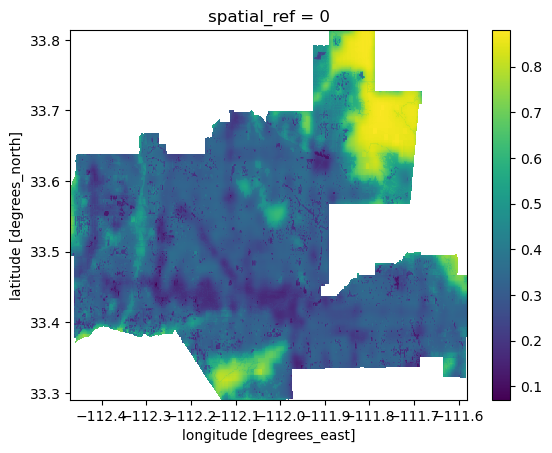

In [14]:
# One band is expected since one index
fig, ax = plt.subplots()
bii_2017_clip.plot(ax=ax)

[Text(0, 33.2, ''),
 Text(0, 33.300000000000004, ''),
 Text(0, 33.400000000000006, ''),
 Text(0, 33.5, ''),
 Text(0, 33.6, ''),
 Text(0, 33.7, ''),
 Text(0, 33.800000000000004, ''),
 Text(0, 33.900000000000006, '')]

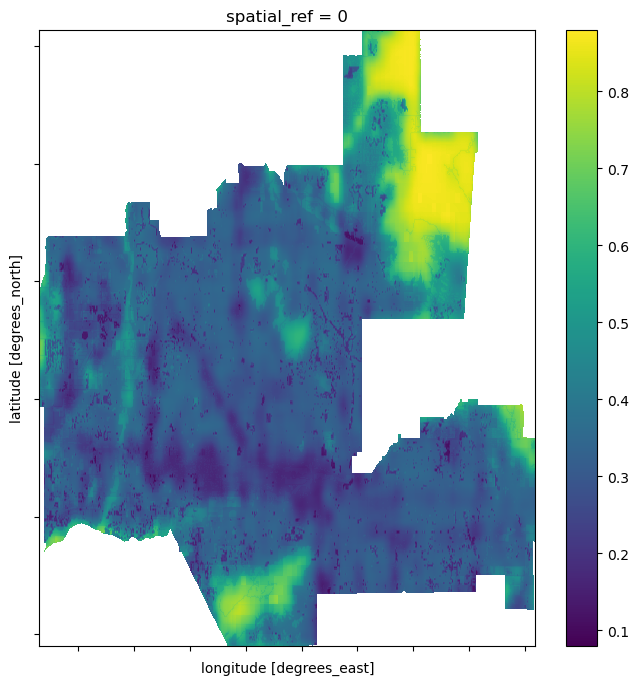

In [35]:
# One band is expected since one index
fig, ax = plt.subplots(figsize = (8,8))
bii_2020_clip.plot(ax=ax)

ax.set_xticklabels([]) # Turn off x axis
ax.set_yticklabels([])  # Turn off y axis

In [16]:
# Want those B11 values exceeding .75
exceed_2017 = bii_2017_clip >= .75 # T if exceeded, F is not
exceed_2020 = bii_2020_clip >= .75  # T if exceeded, F is not

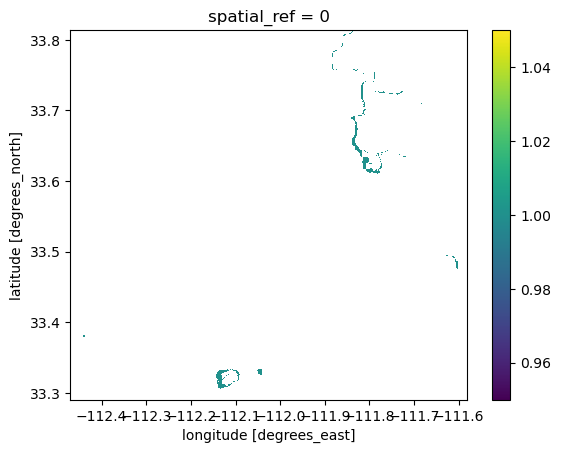

In [83]:
diff_mask = exceed_2017 ^ exceed_2020

#loss_mask = (exceed_2017 == True) & (exceed_2020 == False)

loss_numeric = diff_mask.where(diff_mask, other = np.nan)

#loss_numeric = loss_mask.astype(int)

loss_numeric.plot()

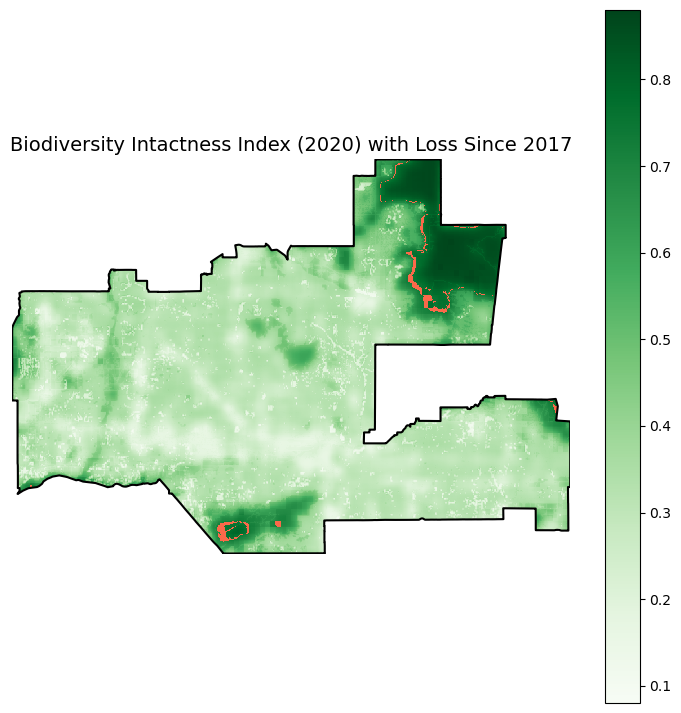

In [84]:
fig, ax = plt.subplots(figsize=(9,9))

bii_2020_clip.plot(
    ax=ax,
    cmap="Greens",
    add_colorbar=True
)


loss_numeric.plot(
    ax=ax,
    cmap= "Reds",
    add_colorbar=False
)


phoenix.boundary.plot(ax=ax, edgecolor="black", linewidth=1.5)

ax.set_title("Biodiversity Intactness Index (2020) with Loss Since 2017", fontsize=14)
ax.set_axis_off()

plt.show()


In [22]:
# Calculate the percent of pixels above .75 (exceed/total)
perc_2017 = (exceed_2017.sum().item()/exceed_2017.count().item())*100

perc_2020 = (exceed_2020.sum().item()/exceed_2020.count().item())*100

print(f"About {perc_2017}% area of the Phoenix subdivision had a BII of at least 0.75 in 2017")

print(f"About {perc_2020}% area of the Phoenix subdivision had a BII of at least 0.75 in 2017")

About 4.181263752447286% area of the Phoenix subdivision had a BII of at least 0.75 in 2017
About 3.8092762964118023% area of the Phoenix subdivision had a BII of at least 0.75 in 2017


## Data Analysis
1. **Data Exploration** 
Explore the data and write a brief summary of the information you obtained from the preliminary information.

2. Create a map showing the Phoenix subdivision within its broader geographic context. You may use any vector or raster datasets to create your map. Be sure to include citations or descriptions for these datasets at the top of your notebook too. You may also want to check out the contextily package to add a base map.



3. Calculate the percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2017. Obtain the same calculation for 2020. Before you start coding, take a moment to write step-by-step instructions for yourself about how to get this result. You don’t need to include these in your notebook, but you should have a plan before starting your code.



4. Create a visualization showing the area with BII>=0.75 in 2017 that was lost by 2020. Here’s an example:


5. Under your BII visualization write a brief description of the results you obtianed in this task.
